**Simple Algorithm for Single Level JPEG Compression Detection**

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided

In [5]:
# Helper functions

def zero_pad_img(Y):
  mx,my = Y.shape
  x = int(np.ceil((mx%8)/8)*8+mx//8*8)
  y = int(np.ceil((my%8)/8)*8+my//8*8)
  img = np.zeros((x,y), dtype = np.uint8)
  img[0:mx,0:my]=Y
  return img


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def get_DCT_coefs(img):
  w, h = img.shape
  dct_output = np.zeros((8,8,int(w*h/64)), dtype=int)
  ci=0
  for i in range(0, w, 8):
    for j in range(0, h, 8):
        image_part = img[i:i+8, j:j+8]
        dct_coefs = cv2.dct(image_part)
        dct_output[:, :, ci] = dct_coefs
        ci+=1
  return dct_output


def get_DC_histogram(DC, N=2000):
  bins = range(0,N,1)
  hcount = np.histogram(DC, bins=bins, density=True)[0]
  return hcount


def FFT_output(hcount):
  x = np.fft.fft(hcount.astype(float))
  x = np.fft.fftshift(x)
  x = 20*np.log10(np.abs(x))
  x = smooth(x, 3)
  return x


def find_quality_level(x, N):
  # Find distance between peaks in FFT

  # Use a reference magnitude
  ref = x[N//2-1]

  # Find locations that are 12 db lower than max magn.
  r=np.where((x-ref)>-12)

  local_maxs=[]
  for i in r[0]:
    if i<3 or i>x.shape[0]-3: # ignore the edges of FFT
      continue

    # Find local peaks that have snr greater than 1 dB with 3*2 pixel width
    if x[i]>x[i-1] and x[i]>x[i+1] and x[i]>x[i-3]+1 and x[i]>x[i+3]+1:
      local_maxs.append(i)

  # Use lookup table and get the compression level
  K_table = np.array([1, 3, 4, 6, 7, 9, 12, 19, 39, 100]) # This is the lookup table that I extracted using non-compressed image set
  if len(local_maxs)==1: # if no local max
    Q=100
  else:
    # Select the most frequent distance between peaks
    d = np.bincount(np.diff(local_maxs)).argmax()
    K = d/N*100

    # Use lookup table, interpolate and find compression
    for i in range(9):
      if K>=K_table[i] and K<K_table[i+1]:
        Q=(i+1)*10+(K-K_table[i])/(K_table[i+1]-K_table[i])*10

  print("K:", K)
  return round(Q), local_maxs

K: 1.25
Quality: 11


Text(0.5, 0.98, 'FFT Output, Estimated Quality = 11')

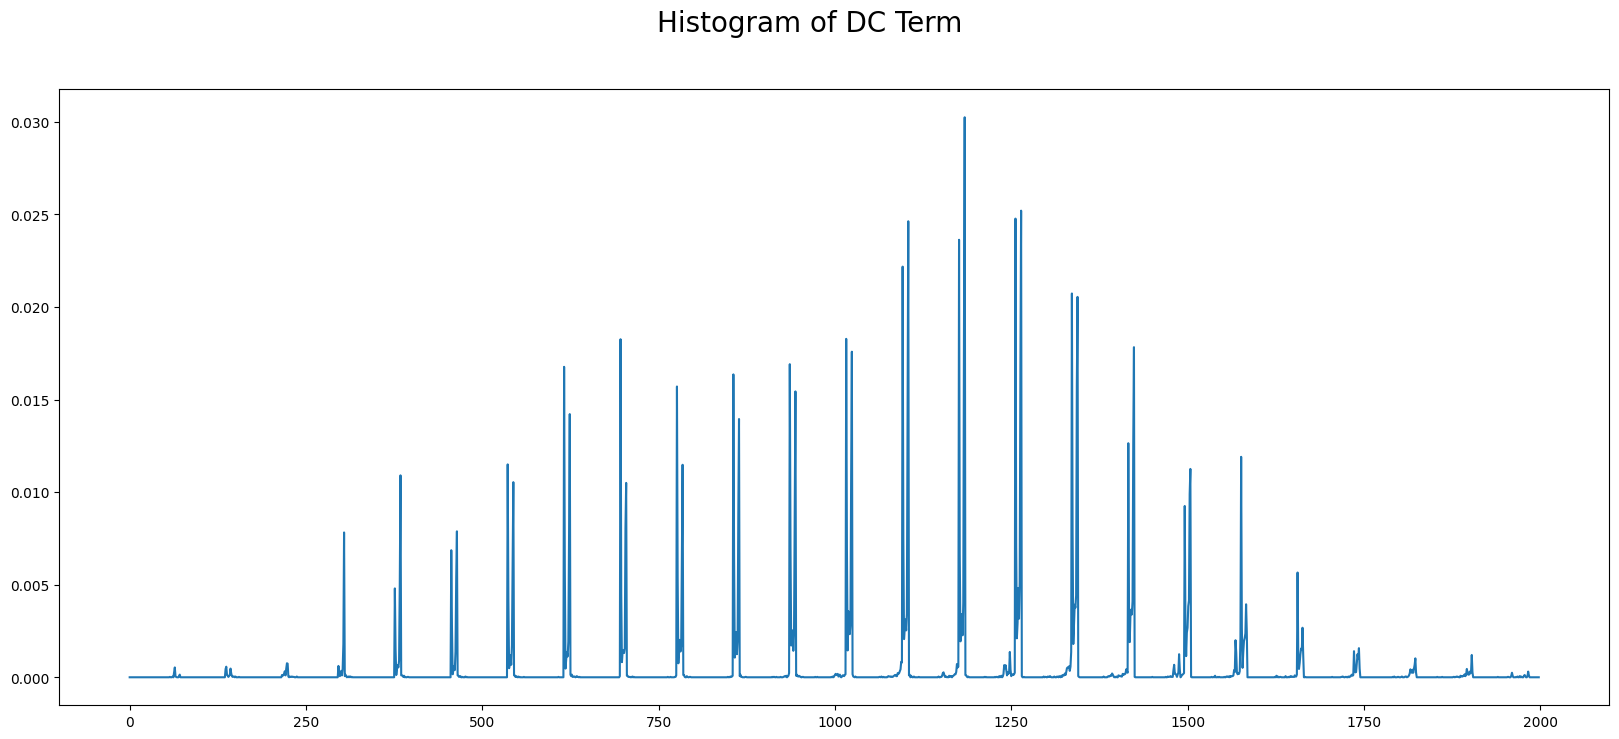

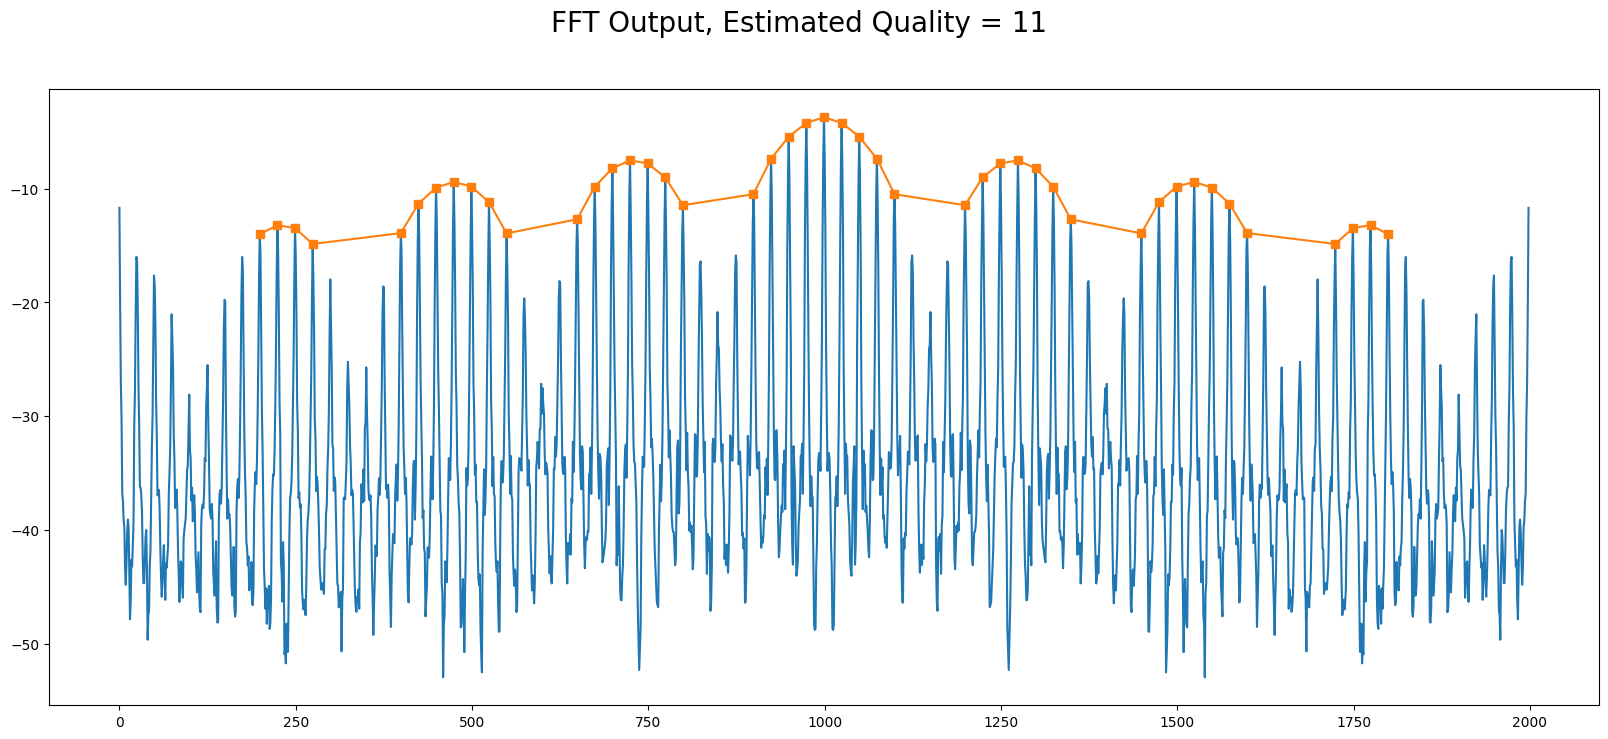

In [10]:
# Algorithm for Single Level JPEG Compression Detection

# 1. Read image
img = Image.open("sample_quality_10.jpg")

# 2. Use luminance channel
img = img.convert('YCbCr')
Y = np.array(img)[:,:,0]

# 3. Zero pad to multiple of 8 at each side
img = zero_pad_img(Y)
img = img.astype(np.float64)

# 4. Get DCT coefs.
dct_output = get_DCT_coefs(img)

# 5. DC term
DC = dct_output[0,0,:]

# 6. DC histogram
N=2000 # number of bins in histogram
hcount=get_DC_histogram(DC, N)

# 7. FFT of DC term
x = FFT_output(hcount)

# 8. Quality level
Q, local_maxs = find_quality_level(x, N)
print("Quality:",Q)

# 9.Plot histogram and FFT peaks
fig = plt.figure(figsize=(20,8))
plt.plot(hcount)
fig.suptitle("Histogram of DC Term",fontsize=20)

fig = plt.figure(figsize=(20,8))
plt.plot(x)
plt.plot(local_maxs, x[local_maxs], marker='s')
fig.suptitle("FFT Output, Estimated Quality = " + str(Q),fontsize=20)

